In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


First step is to install all the dependencies that we are going to need later


In [2]:
!pip install -q transformers 
!pip install -q peft
!pip install -q evaluate

We start by fetching the IMDB dataset with two categories from Hugging Face. This dataset is designed for binary sentiment classification and boasts a significantly larger volume of data compared to earlier benchmark datasets. Within this dataset, we have at our disposal 25,000 strongly polarized movie reviews for the purpose of training, along with another 25,000 for testing. Moreover, there exists an additional pool of unlabeled data that can be utilized as needed

In [10]:
from datasets import load_dataset

dataset = load_dataset("imdb")


  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
data=pd.DataFrame(dataset["train"])

<Axes: >

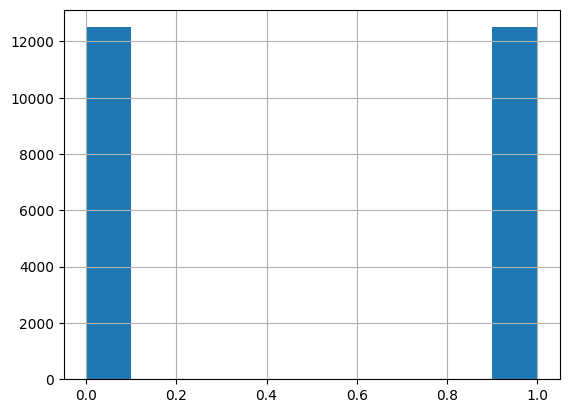

In [12]:
data["label"].hist()

It's common knowledge that text processing necessitates the use of a tokenizer, along with the implementation of a padding and truncation strategy to manage variable sequence lengths effectively.






In [13]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

We can create a smaller dataset for fine tuning to save time and make it less complex.



In [14]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

Following that, we establish an LORA configuration object using Hugging Face's Efficient Fine-Tuning (PEFT) parameters. The task_Type parameter specifies the task type for which the model will undergo fine-tuning. The 'r' parameter denotes the dimensions of 'A' and 'B,' as previously mentioned. Additionally, the 'lora_alpha' serves as a scaling factor, determining the relative significance of the weights in 'A' and 'B' in relation to the model's original parameters.

In [15]:
from peft import LoraConfig, TaskType

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=1, lora_alpha=1, lora_dropout=0.1
)


Subsequently, we insert the 'A' and 'B' matrices into our model by invoking the 'get_peft_model' function.

In [20]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased', 
    num_labels=2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from peft import get_peft_model
model = get_peft_model(model, lora_config)


In [22]:
#from transformers import TrainingArguments

#training_args = TrainingArguments(output_dir="test_trainer")

The Trainer does not inherently perform automatic model performance evaluation throughout the training process. To evaluate the model, you'll have to provide Trainer with a custom function for calculating and reporting metrics. You can utilize the 'evaluate.load' function from the 🤗 Evaluate library, which offers a straightforward accuracy function for this purpose. For more details, please refer to the quick tour on how to use it.

In [23]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

Call compute on metric to calculate the accuracy of your predictions. Before passing your predictions to compute, you need to convert the predictions to logits 

In [24]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [25]:
'''
training_args = TrainingArguments(
output_dir='./out',
num_train_epochs=1000,
per_device_train_batch_size=2,
per_device_eval_batch_size=2,
warmup_steps=500,
weight_decay=0.01,
logging_dir='./logs',
logging_steps=10,
)

trainer = Trainer(
model=model,
args=training_args,
train_dataset=small_train_dataset,
eval_dataset=small_eval_dataset)

trainer.train()
'''

"\ntraining_args = TrainingArguments(\noutput_dir='./out',\nnum_train_epochs=1000,\nper_device_train_batch_size=2,\nper_device_eval_batch_size=2,\nwarmup_steps=500,\nweight_decay=0.01,\nlogging_dir='./logs',\nlogging_steps=10,\n)\n\ntrainer = Trainer(\nmodel=model,\nargs=training_args,\ntrain_dataset=small_train_dataset,\neval_dataset=small_eval_dataset)\n\ntrainer.train()\n"

Following that, construct a TrainingArguments class that encompasses all the hyperparameters available for tuning, as well as flags for enabling various training options.






In [26]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch",
                                 num_train_epochs=25,)

In [27]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [28]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.676660,0.580000
2,No log,0.672455,0.600000
3,No log,0.667272,0.616000
4,No log,0.661497,0.631000
5,No log,0.655566,0.644000
6,No log,0.645592,0.656000
7,No log,0.630616,0.673000
8,0.675900,0.613377,0.676000
9,0.675900,0.596668,0.705000
10,0.675900,0.575527,0.702000


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=1575, training_loss=0.5626615663558717, metrics={'train_runtime': 1678.0942, 'train_samples_per_second': 14.898, 'train_steps_per_second': 0.939, 'total_flos': 6580725657600000.0, 'train_loss': 0.5626615663558717, 'epoch': 25.0})

In [29]:
model.print_trainable_parameters()


trainable params: 39,940 || all params: 108,350,212 || trainable%: 0.03686194910260074
